Welcome to one of the collaborative Jupyter/Spark environments in ZHAW. You are not yet connected to Sparky by default. However, the necessary code template makes this a quick process. Keep in mind that you are sharing both the Jupyter environment and the Sparky cluster with others. Custom Python packages on the notebook/Spark driver side are installed with %pip install.

In [1]:
zhawaccount = 'hasslrob'# TODO set this to your ZHAW-Kürzel

In [2]:
import sparky
import pyspark
import pandas as pd
#import slash
import pyspark.sql
sc = sparky.connect(f"sparknotebook-{zhawaccount}", 2)
# spark = pyspark.sql.SparkSession.builder.getOrCreate()

~~~ Sparky module loaded ~~~


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/28 20:08:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/28 20:08:20 WARN Utils: Service 'sparkDriver' could not bind on port 5555. Attempting port 5556.
24/06/28 20:08:20 WARN Utils: Service 'sparkDriver' could not bind on port 5556. Attempting port 5557.
24/06/28 20:08:20 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 4444. Attempting port 4445.
24/06/28 20:08:20 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 4445. Attempting port 4446.


Attached to Sparky cluster context from jupyter-secondary as sparknotebook-hasslrob.
Requested 2 cores; real number might be less.


### 0. Data Overview

In [3]:
customer_master = pd.read_csv('ExchangeRates.csv')
customer_master.tail(30)

,ActiveDate,LocalCurrency,ForeignCurrency,ExchangeRate
330,20201031,CHF,USD,1.001110
331,20201130,CHF,USD,0.949692
332,20201231,CHF,USD,0.923214
333,20210131,CHF,USD,0.926059
334,20210228,CHF,USD,0.936717
335,20210331,CHF,USD,0.916682
336,20210430,CHF,USD,0.896003
337,20210531,CHF,USD,0.910232
338,20210630,CHF,USD,0.900792
339,20210731,CHF,USD,0.872630


### 1. Install and Import dependencies

In [4]:
%pip install plotly
%pip install prophet

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

  Using cached prophet-1.1.5-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.4 MB)
  Using cached cmdstanpy-1.2.4-py3-none-any.whl (94 kB)
  Using cached matplotlib-3.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Using cached holidays-0.51-py3-none-any.whl (1.0 MB)
  Using cached tqdm-4.66.4-py3-none-any.whl (78 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl (38 kB)
  Using cached stanio-0.5.0-py3-none-any.whl (8.0 kB)
  Using cached contourpy-1.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (306 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.53.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
  Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.4 MB)
  Using cached pillow-10.3.0-cp311-cp311-manylinux_2_28_x86_64.whl (4.5 MB)
  Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)


### 2. Read in Data and Process Dates

In [6]:
df_currate = pd.read_csv('ExchangeRates.csv')

df_currate.dtypes

ActiveDate           int64
LocalCurrency       object
ForeignCurrency     object
ExchangeRate       float64
dtype: object

In [7]:
# ActiveDate hase to be in DateTime format for prophet to work
df_currate['ActiveDate'] = pd.to_datetime(df_currate['ActiveDate'], format='%Y%m%d', errors='coerce')

# Identify rows with invalid dates
invalid_dates = df_currate[df_currate['ActiveDate'].isnull()]
print("Rows with invalid dates:")
print(invalid_dates)

df_currate.head()
df_currate.dtypes

Rows with invalid dates:
    ActiveDate LocalCurrency ForeignCurrency  ExchangeRate
31         NaT           CHF             CHF      1.000000
75         NaT           CHF             DKK      0.127904
118        NaT           CHF             EUR      0.953400
172        NaT           CHF             GBP      1.113069
215        NaT           CHF             JPY      0.005866
257        NaT           CHF             NOK      0.082962
302        NaT           CHF             SEK      0.085011
346        NaT           CHF             USD      0.880657


ActiveDate         datetime64[ns]
LocalCurrency              object
ForeignCurrency            object
ExchangeRate              float64
dtype: object

In [8]:
# Drop rows with invalid dates
df_currate = df_currate.dropna(subset=['ActiveDate'])

# Sort the DataFrame by 'ActiveDate' in ascending order
df_currate = df_currate.sort_values(by='ActiveDate')

# Rename columns to 'ds' and 'y' for Prophet compatibility
df_currate.rename(columns={'ActiveDate': 'ds', 'ExchangeRate': 'y'}, inplace=True)

df_currate.head()

,ds,LocalCurrency,ForeignCurrency,y
0,2019-06-30,CHF,CHF,1.000000
225,2019-06-30,CHF,NOK,0.107947
86,2019-06-30,CHF,EUR,1.098000
270,2019-06-30,CHF,SEK,0.108594
43,2019-06-30,CHF,DKK,0.147656


### 3. Create DataFrames for three currencies

In [9]:
chf_rows_df = df_currate[df_currate['ForeignCurrency'] == 'CHF']
eur_rows_df = df_currate[df_currate['ForeignCurrency'] == 'EUR']
dkk_rows_df = df_currate[df_currate['ForeignCurrency'] == 'DKK']
gpb_rows_df = df_currate[df_currate['ForeignCurrency'] == 'GPB']
usd_rows_df = df_currate[df_currate['ForeignCurrency'] == 'USD']

# print the most current values
print(chf_rows_df.tail(5))
print(eur_rows_df.tail(5))
print(dkk_rows_df.tail(5))
print(gpb_rows_df.tail(5))
print(usd_rows_df.tail(5))

           ds LocalCurrency ForeignCurrency    y
30 2022-01-31           CHF             CHF  1.0
41 2022-03-31           CHF             CHF  1.0
32 2022-03-31           CHF             CHF  1.0
33 2022-04-30           CHF             CHF  1.0
34 2022-05-31           CHF             CHF  1.0
            ds LocalCurrency ForeignCurrency         y
128 2022-03-31           CHF             EUR  0.970383
119 2022-03-31           CHF             EUR  0.976600
139 2022-04-06           CHF             EUR  0.970000
120 2022-04-30           CHF             EUR  0.978700
121 2022-05-31           CHF             EUR  0.981800
           ds LocalCurrency ForeignCurrency         y
74 2022-01-31           CHF             DKK  0.125392
76 2022-03-31           CHF             DKK  0.130946
85 2022-03-31           CHF             DKK  0.130219
77 2022-04-30           CHF             DKK  0.131223
78 2022-05-31           CHF             DKK  0.131630
Empty DataFrame
Columns: [ds, LocalCurrency, Foreign

### 4. Explanation and Execution of Forecasts

**ds (Date Series):**

This column contains the timestamps for the forecasted values. It corresponds to the future dates for which the forecast has been generated.

**yhat (Forecasted Value):**

This column contains the forecasted values of the time series. It is the primary output of the Prophet model and represents the predicted values for the corresponding dates in the ds column.

**yhat_lower (Lower Bound of Forecast):**

This column contains the lower bound of the forecasted values' uncertainty interval. It provides a conservative estimate of the forecast, giving an idea of the potential minimum value the forecast might take.

**yhat_upper (Upper Bound of Forecast):**

This column contains the upper bound of the forecasted values' uncertainty interval. It provides a liberal estimate of the forecast, giving an idea of the potential maximum value the forecast might take.

In [10]:
# Initialize the Prophet model
model = Prophet(interval_width=0.95, daily_seasonality=True)

# Fit the model on the data
model.fit(usd_rows_df) # change name DataFrame as parameter for other currencies

# Create a DataFrame to hold future dates for forecasting
future = model.make_future_dataframe(periods=36, freq='M')  # Forecasting 36 months into the future from 2022-06-01 on

# Generate the forecast
forecast = model.predict(future)

# Print the 12 last forecasted months
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

20:09:54 - cmdstanpy - INFO - Chain [1] start processing
20:09:54 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
61,2024-06-30,0.954281,0.787152,1.093376
62,2024-07-31,0.912163,0.734109,1.058709
63,2024-08-31,0.969411,0.777231,1.125420
64,2024-09-30,0.923569,0.718218,1.077602
65,2024-10-31,0.998649,0.788003,1.168385
66,2024-11-30,0.963896,0.742409,1.137191
67,2024-12-31,0.868688,0.630146,1.052700
68,2025-01-31,0.929772,0.686668,1.125877
69,2025-02-28,0.956043,0.693995,1.160365
70,2025-03-31,0.931245,0.652463,1.141555


### 5. Plotting Results and Forecasts

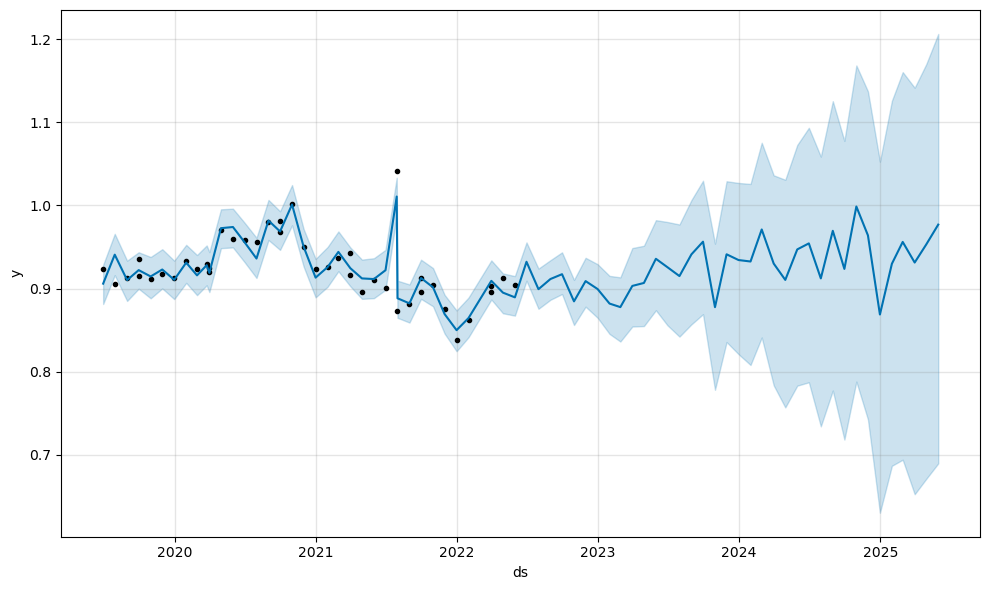

In [11]:
# Plotting the results
fig1 = model.plot(forecast)
plt.show()

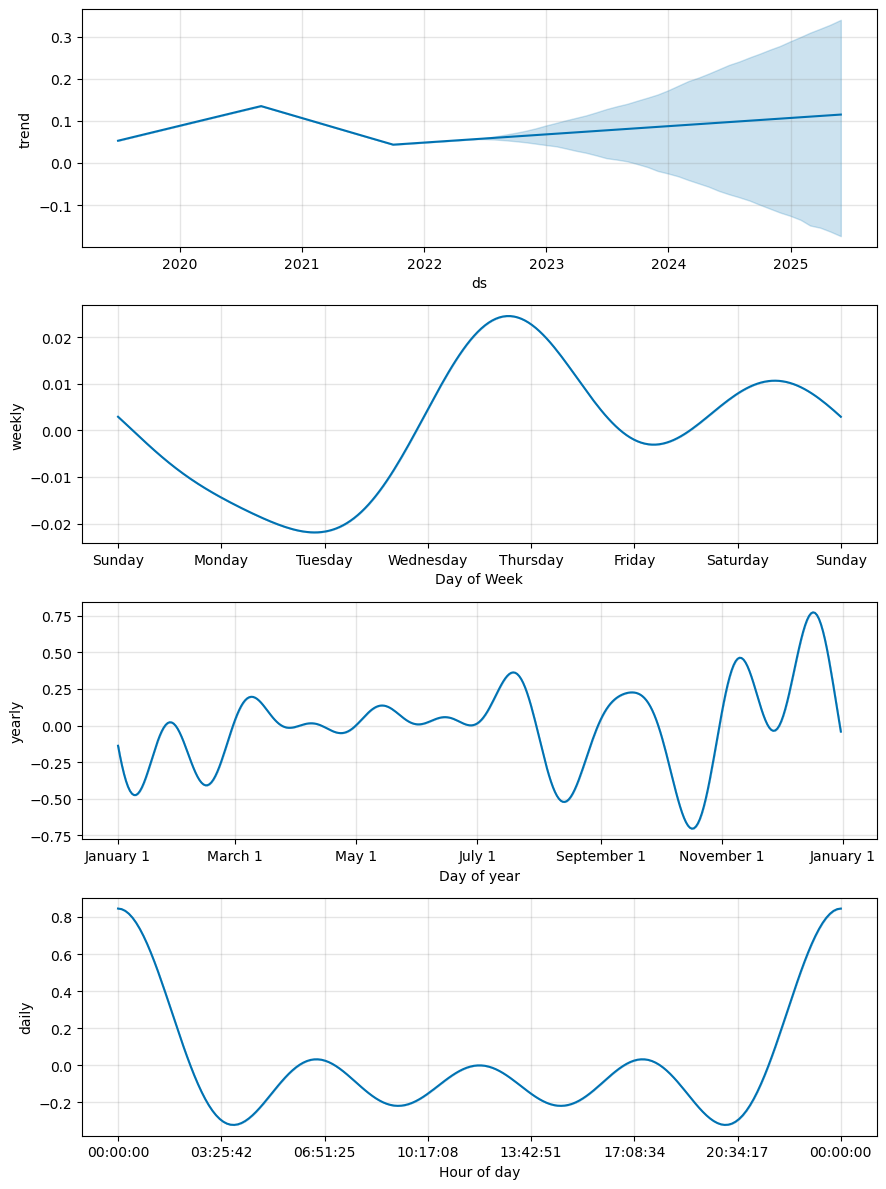

In [12]:
# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()

In [13]:
sc.stop()

Sources:
- https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-prophet-5015928e402a
- https://www.kaggle.com/code/kakkarot/starter-hourly-energy-consumption-b71f2600-a
- https://www.youtube.com/watch?v=KvLG1uTC-KU